In [32]:
import pandas as pd
import xarray as xr
import numpy as np
from linopy import Model
import pygwalker as pyg

In [37]:
### Loading the data and convert to xarray DataSet

# Technologies data:
tech_param = pd.read_csv('data/technologies.csv',index_col=0)
tech_param = tech_param.drop("Coal")
tech_param = tech_param.drop("CCGT")
tech_param = tech_param.drop("GT")
tech_param = tech_param.drop("Fioul")


# Demand:
demand = pd.read_csv('data/demand.csv',index_col=0).to_xarray()

# Avaibility:
AF = pd.read_csv('data/AF.csv',index_col=0) 
for tech in tech_param.index:
    if tech not in AF.columns:
        AF.loc[:,tech] = tech_param.loc[tech, "Availability"] 
tech_param = tech_param.to_xarray()

# Global parameters:
general_parameters = pd.read_csv('data/global_parameters.csv',index_col=0)

In [38]:
### Sets
Time = demand.get_index("Time")
Tech = tech_param.get_index("Technologies")


# Technologies related
TECH_MAX_CAP = tech_param['Maximum capacity']
MARGINAL_FUEL_COST = tech_param['Fuel costs']/tech_param['Rated efficiency']
CO2_INTENSITY = tech_param['Fuel CO2 content']/tech_param['Rated efficiency']
TECH_PHI = tech_param["Discount rate"]/(1-(1+tech_param["Discount rate"])**(-tech_param["Lifetime"]))
TECH_IC = TECH_PHI*tech_param['Investment cost']
DELTA_MAX_UP = tech_param['Ramp-up rate']
DELTA_MAX_DOWN = tech_param['Ramp-down rate']
AF = AF[Tech]
AF  = xr.DataArray(AF,coords=[Time,Tech])
LEGACY = tech_param["Legacy capacity"]

# Configuration and scenario parameters
DEMAND = demand["Demand"]
TS = float(general_parameters.Value.loc['Time step'])
VOLL = float(general_parameters.Value.loc['VOLL'])
CO2_PRICE = float(general_parameters.Value.loc['CO2_price'])
CO2_BOUND = float(general_parameters.Value.loc['CO2_bound'])

In [39]:
### Create the model instance

m = Model()

### Create the variables

cap_tech = m.add_variables(lower = 0, coords = [Tech], name = 'cap_tech') # Installed capacity of the technologies [MW]
g = m.add_variables(lower = 0, coords = [Tech, Time], name = 'g')        # Generated power [MW]
fcd = m.add_variables(lower = 0, coords = [Tech, Time], name = 'fcd')    # Fuel cost definition [EUR/h]


co2_emissions =  m.add_variables(lower = 0, name = 'co2_emissions')     # Combined CO2 emissions [tCO2eq]
ens = m.add_variables(lower = 0, coords = [Time], name = 'ens')           # Energy no served [MWh]

curt = m.add_variables(lower = 0, coords = [Time])                      # Curtailment [MWh]

# Create the constraints

# Technology sizing
cap_max_tech = m.add_constraints(cap_tech <= TECH_MAX_CAP, name = "cap_max_tech")
cap_min_tech = m.add_constraints(cap_tech >= LEGACY, name = "cap_min_tech")
power_max = m.add_constraints(g <= AF*cap_tech, name= 'power_max')


# Market clearing
mcc = m.add_constraints(g.sum(dims = 'Technologies') + ens == DEMAND, name = 'mcc')

# Limit on energy not served
ens_lim = m.add_constraints(ens<=DEMAND, name = 'ens_lim')

# Costs
fuel_cost = m.add_constraints(fcd == MARGINAL_FUEL_COST*g, name="fuel_cost")

# CO2 Emissions
co2_account =  m.add_constraints(co2_emissions == (CO2_INTENSITY*g).sum(dims=["Technologies", "Time"]), name="co2 account")
co2_bound = m.add_constraints(co2_emissions <= CO2_BOUND, name = "co2_bound")

### Curtailment evaluation.
RE_MASK = xr.DataArray(np.array([0,0,1,1,1,0]), coords = [Tech])
curt_eval = m.add_constraints(curt == ((AF*cap_tech-g)*RE_MASK).sum(dims = 'Technologies') , name = 'curt')

# Add the objective function
total_cost = (TECH_IC*cap_tech).sum(dim="Technologies") + (TS*fcd).sum(dims = ['Technologies', 'Time']) + (VOLL*TS*ens).sum(dims ='Time')
m.add_objective(total_cost)

In [40]:
m.solve("gurobi")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2551043
Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Read LP format model from file /tmp/linopy-problem-25e1ne8o.lp
Reading time = 0.00 seconds
obj: 494 rows, 455 columns, 1132 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6354 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Optimize a model with 494 rows, 455 columns and 1132 nonzeros
Model fingerprint: 0x52b0fdb0
Coefficient statistics:
  Matrix range     [1e-01, 6e+00]
  Objective range  [1e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 2e+05]
Presolve removed 271 rows and 227 columns
Presolve time: 0.01s
Presolved: 223 rows, 228 columns, 731 n

('ok', 'optimal')

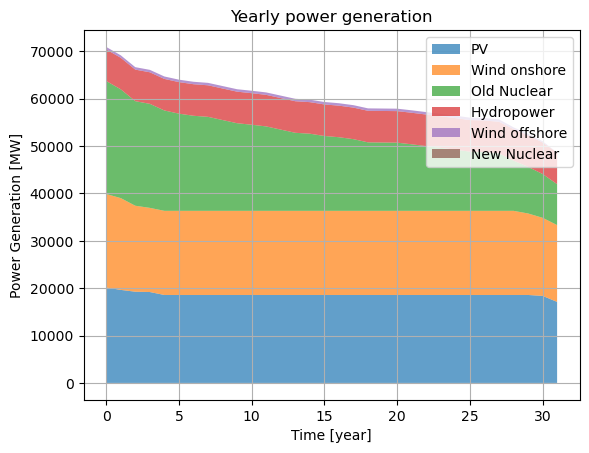

In [41]:
import matplotlib.pyplot as plt

generation_df = g.solution.to_dataframe().unstack(level=0)
generation_df.columns = generation_df.columns.droplevel(0)
total_production = generation_df.sum()
sorted_columns = total_production.sort_values(ascending=False).index

generation_df = generation_df[sorted_columns].apply(lambda x: x.sort_values(ascending=False).values, axis=0)

bottom_stack = np.zeros(32)
for column in generation_df.columns:
    plt.fill_between(range(32), bottom_stack, bottom_stack + generation_df[column], label=column, alpha=0.7)
    bottom_stack += generation_df[column]
plt.xlabel("Time [year]")
plt.ylabel("Power Generation [MW]")
plt.title("Yearly power generation")
plt.legend()
plt.grid()
plt.show()

<Axes: xlabel='Technologies'>

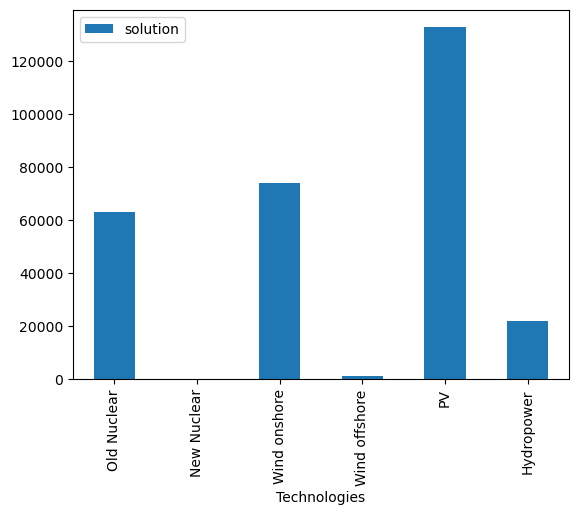

In [42]:
m.objective
cap_tech.solution.to_dataframe().plot(kind="bar")
